## Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary

PATH = os.getcwd()

train_df = pd.read_csv(f'{PATH}\\train.csv', low_memory=False)
test_df = pd.read_csv(f'{PATH}\\test.csv', low_memory=False)

def display_all(df):
    with pd.option_context("display.max_rows", 100): 
        with pd.option_context("display.max_columns", 100): 
            display(df)

In [2]:
'''
**Problem Statement**

An online question and answer platform has hired you as a data scientist to identify the best question authors on the platform.
This identification will bring more insight into increasing the user engagement. Given the tag of the question, number of views
received, number of answers, username and reputation of the question author, the problem requires you to predict the upvote 
count that the question will receive.

**DATA DICTIONARY**
 
- Variable	          ----------- Definition
- ID	              ----------- Question ID
- Tag	              ----------- Anonymised tags representing question category
- Reputation	      ----------- Reputation score of question author
- Answers	          ----------- Number of times question has been answered
- Username	          ----------- Anonymised user id of question author
- Views	              ----------- Number of times question has been viewed
- Upvotes (Target)    ----------- Number of upvotes for the question
''';

In [3]:
train_df.head()

,ID,Tag,Reputation,Answers,Username,Views,Upvotes
0,52664,a,3942.0,2.0,155623,7855.0,42.0
1,327662,a,26046.0,12.0,21781,55801.0,1175.0
2,468453,c,1358.0,4.0,56177,8067.0,60.0
3,96996,a,264.0,3.0,168793,27064.0,9.0
4,131465,c,4271.0,4.0,112223,13986.0,83.0


In [4]:
'Train', train_df.shape, len(set(train_df.ID.values)), len(set(train_df.Username.values)), 'Test', \
test_df.shape, len(set(test_df.ID.values)), len(set(test_df.Username.values))

('Train', (330045, 7), 330045, 141802, 'Test', (141448, 6), 141448, 79351)

In [3]:
def Intersection(lst1, lst2):
    return len(list(set(lst1).intersection(lst2)))

## Username

In [7]:
Intersection(train_df.Username, test_df.Username),\
Intersection(train_df.Reputation, test_df.Reputation),\
Intersection(train_df.Views, test_df.Views)

(45414, 13211, 37143)

First of all, let's see how many different User's we have on both datasets

In [8]:
man_train_list = train_df.Username.unique()
man_test_list = test_df.Username.unique()
print("Train: {0}".format(len(man_train_list)))
print("Test: {0}".format(len(man_test_list)))

Train: 141802
Test: 79351


- **Unique User's in Test are close to $1$/$2$ of user's in Train...**

In [4]:
temp1 = train_df.groupby('Username').count().iloc[:,-1]
temp2 = test_df.groupby('Username').count().iloc[:,-1]
df_man = pd.concat([temp1,temp2], axis = 1, join = 'outer')
df_man.columns = ['train_count','test_count']
print(df_man.head(20))

          train_count  test_count
Username                         
0                 1.0         NaN
1                 1.0         NaN
2                 1.0         NaN
3                 1.0         NaN
4                 NaN         1.0
5                 1.0         NaN
6                 1.0         NaN
7                 NaN         1.0
8                 NaN         1.0
9                 1.0         NaN
10                1.0         NaN
11                1.0         NaN
12                1.0         NaN
13                1.0         NaN
14                1.0         NaN
15                NaN         1.0
16                NaN         1.0
17                1.0         NaN
18                1.0         NaN
19                NaN         1.0


- **Some Users have entries only in one of the two datasets**

In [13]:
print(df_man.sort_values(by = 'train_count', ascending = False).head(20))

          train_count  test_count
Username                         
4118            797.0       336.0
17878           608.0       228.0
45704           483.0       205.0
23223           413.0       199.0
62142           408.0       200.0
6697            408.0       190.0
94185           391.0       152.0
59362           355.0       180.0
61217           337.0       151.0
41953           328.0       138.0
12074           326.0       134.0
82170           321.0       136.0
93544           320.0       116.0
58117           310.0       119.0
67129           297.0       168.0
21641           292.0       127.0
22010           269.0       119.0
42835           261.0        96.0
78813           248.0       122.0
80714           248.0       117.0


- **More clearer if one looks at the plots for the cumulative distributions.**

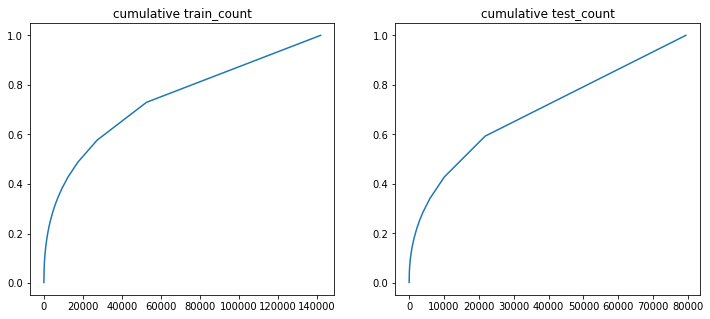

In [20]:
fig, axes = plt.subplots(1,2, figsize = (12,5))
temp = df_man['train_count'].dropna().sort_values(ascending = False).reset_index(drop = True)
axes[0].plot(temp.index+1, temp.cumsum()/temp.sum())
axes[0].set_title('cumulative train_count');

temp = df_man['test_count'].dropna().sort_values(ascending = False).reset_index(drop = True)
axes[1].plot(temp.index+1, temp.cumsum()/temp.sum())
axes[1].set_title('cumulative test_count');

In [21]:
ix20 = int(len(df_man['train_count'].dropna())*0.2)
print("TRAIN: 20% of man ({0}) responsible for {1:2.2f}% of entries".format(ix20,df_man['train_count'].sort_values(ascending = False).cumsum().iloc[ix20]/df_man['train_count'].sum()*100))

ix20 = int(len(df_man['test_count'].dropna())*0.2)
print("TEST: 20% of man ({0}) responsible for {1:2.2f}% of entries".format(ix20, df_man['test_count'].sort_values(ascending = False).cumsum().iloc[ix20]/df_man['test_count'].sum()*100))

TRAIN: 20% of man (28360) responsible for 58.36% of entries
TEST: 20% of man (15870) responsible for 51.00% of entries


- **The man featuring in only one of the two datasets usually have very few entries.**

In [23]:
man_not_in_test = set(man_train_list) - set(man_test_list)
man_not_in_train = set(man_test_list) - set(man_train_list)

print("{} man are featured in train but not in test".format(len(man_not_in_test)))
print("{} man are featured in test but not in train".format(len(man_not_in_train)))

96388 man are featured in train but not in test
33937 man are featured in test but not in train


In [120]:
train_df.loc[list(man_not_in_test)].head()
## Need to drop them blindly...
#train_df.drop(index = train_df.loc[list(man_not_in_test)].index, inplace=True).shape

,ID,Tag,Reputation,Answers,Username,Views,Upvotes
0,52664,a,3942.0,2.0,155623,7855.0,42.0
1,327662,a,26046.0,12.0,21781,55801.0,1175.0
2,468453,c,1358.0,4.0,56177,8067.0,60.0
3,96996,a,264.0,3.0,168793,27064.0,9.0
5,345568,r,440.0,1.0,23866,5577.0,4.0
6,376865,c,147.0,1.0,10759,17184.0,17.0
9,130054,c,2749.0,1.0,10189,227.0,0.0
10,218471,c,1142.0,7.0,71822,141836.0,166.0
11,144119,p,2554.0,1.0,137817,8086.0,42.0
12,155955,s,591.0,4.0,36550,16102.0,19.0


In [24]:
print(df_man.loc[list(man_not_in_test)]['train_count'].describe())
print(df_man.loc[list(man_not_in_train)]['test_count'].describe())

count    96388.000000
mean         1.406721
std          0.902468
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         17.000000
Name: train_count, dtype: float64
count    33937.000000
mean         1.118337
std          0.379317
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          6.000000
Name: test_count, dtype: float64


- **Strong Correlation among them**

In [26]:
df_man.sort_values(by = 'train_count', ascending = False).head(1000).corr()

,train_count,test_count
train_count,1.000000,0.974016
test_count,0.974016,1.000000


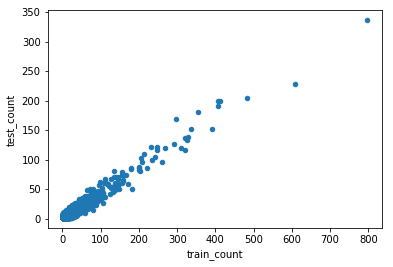

In [5]:
df_man.sort_values(by = 'train_count', ascending = False).plot.scatter(x = 'train_count', y = 'test_count')

In [37]:
temp = df_man['train_count'].sort_values(ascending = False).head(50000)
temp = pd.concat([temp,temp.cumsum()/df_man['train_count'].sum()*100], axis = 1).reset_index()
temp.columns = ['user_id','count','percentage']
print(temp)

       user_id  count  percentage
0         4118  797.0    0.241482
1        17878  608.0    0.425700
2        45704  483.0    0.572043
3        23223  413.0    0.697178
4         6697  408.0    0.820797
5        62142  408.0    0.944417
6        94185  391.0    1.062885
7        59362  355.0    1.170446
8        61217  337.0    1.272554
9        41953  328.0    1.371934
10       12074  326.0    1.470709
11       82170  321.0    1.567968
12       93544  320.0    1.664924
13       58117  310.0    1.758851
14       67129  297.0    1.848839
15       21641  292.0    1.937312
16       22010  269.0    2.018816
17       42835  261.0    2.097896
18       78813  248.0    2.173037
19       80714  248.0    2.248178
20       88986  241.0    2.321199
21       58656  233.0    2.391795
22       71408  231.0    2.461786
23       23032  222.0    2.529049
24       72364  214.0    2.593889
25        2177  209.0    2.657213
26       45253  206.0    2.719629
27       14828  202.0    2.780833
28       93065

In [41]:
set(train_df.Tag)

{'a', 'c', 'h', 'i', 'j', 'o', 'p', 'r', 's', 'x'}

In [15]:
man_list = df_man['train_count'].sort_values(ascending = False).index
ixes = train_df.Username.isin(man_list)
df10000 = train_df[ixes][['Username','Tag']]
tags_dummies = pd.get_dummies(df10000.Tag)
df10000 = pd.concat([df10000,tags_dummies[['a', 'c', 'h', 'i', 'j', 'o', 'p', 'r', 's', 'x']]], axis = 1).drop('Tag', axis = 1)

print("The contributors account for {} entries\n".format(len(df10000)))
print(df10000.head(10))

The contributors account for 330045 entries

   Username  a  c  h  i  j  o  p  r  s  x
0    155623  1  0  0  0  0  0  0  0  0  0
1     21781  1  0  0  0  0  0  0  0  0  0
2     56177  0  1  0  0  0  0  0  0  0  0
3    168793  1  0  0  0  0  0  0  0  0  0
4    112223  0  1  0  0  0  0  0  0  0  0
5     23866  0  0  0  0  0  0  0  1  0  0
6     10759  0  1  0  0  0  0  0  0  0  0
7     54623  0  0  0  0  1  0  0  0  0  0
8    172926  0  0  0  0  1  0  0  0  0  0
9     10189  0  1  0  0  0  0  0  0  0  0


In [18]:
df10000.head(2)

,Username,a,c,h,i,j,o,p,r,s,x
0,155623,1,0,0,0,0,0,0,0,0,0
1,21781,1,0,0,0,0,0,0,0,0,0


In [17]:
import itertools

last_names = ['Mary',  'Patricia',  'Linda',  'Barbara',  'Elizabeth',  
               'Jennifer',  'Maria',  'Susan',  'Margaret',  'Dorothy',
               'James', 'John', 'Robert', 'Michael', 'William', 'David',
               'Richard', 'Charles', 'Joseph', 'Thomas','Smith', 'Johnson', 'Williams', 'Jones', 'Brown', 'Davis', 'Miller', 'Wilson', 'Moore', 
 'Taylor', 'Anderson', 'Thomas', 'Jackson', 'White', 'Harris', 'Martin', 'Thompson', 'Garcia', 
 'Martinez', 'Robinson', 'Clark', 'Rodriguez', 'Lewis', 'Lee', 'Walker', 'Hall', 'Allen', 'Young',
 'Hernandez', 'King', 'Wright', 'Lopez', 'Hill', 'Scott', 'Green', 'Adams', 'Baker', 'Gonzalez', 'Nelson', 
 'Carter', 'Mitchell', 'Perez', 'Roberts', 'Turner', 'Phillips', 'Campbell', 'Parker', 'Evans', 'Edwards', 'Collins']
 
first_names = ['Smith', 'Johnson', 'Williams', 'Jones', 'Brown', 'Davis', 'Miller', 'Wilson', 'Moore', 
 'Taylor', 'Anderson', 'Thomas', 'Jackson', 'White', 'Harris', 'Martin', 'Thompson', 'Garcia', 
 'Martinez', 'Robinson', 'Clark', 'Rodriguez', 'Lewis', 'Lee', 'Walker', 'Hall', 'Allen', 'Young',
 'Hernandez', 'King', 'Wright', 'Lopez', 'Hill', 'Scott', 'Green', 'Adams', 'Baker', 'Gonzalez', 'Nelson', 
 'Carter', 'Mitchell', 'Perez', 'Roberts', 'Turner', 'Phillips', 'Campbell', 'Parker', 'Evans', 'Edwards', 'Collins','Mary',  'Patricia',  'Linda',  'Barbara',  'Elizabeth',  
               'Jennifer',  'Maria',  'Susan',  'Margaret',  'Dorothy',
               'James', 'John', 'Robert', 'Michael', 'William', 'David',
               'Richard', 'Charles', 'Joseph', 'Thomas']

names = [first + ' ' + last for first,last in (itertools.product(first_names, last_names))]

# shuffle them
np.random.seed(12345)
np.random.shuffle(names)

dictionary = dict(zip(man_list, names))
df10000.loc[df10000.Username.isin(dictionary), 'Username' ] = df10000['Username'].map(dictionary)
print(df10000.head())

TypeError: bad operand type for unary +: 'str'

In [19]:
# see if the name coincides
print(names[:10])
print(df10000.groupby('Username').count().sort_values(by = 'a', ascending = False).head(10))

['Barbara Smith', 'Green Wright', 'Adams Jackson', 'Miller Campbell', 'Taylor Martin', 'Williams Lopez', 'Wright Lee', 'James James', 'Patricia Lee', 'Jackson Anderson']
            a    c    h    i    j    o    p    r    s    x
Username                                                  
4118      797  797  797  797  797  797  797  797  797  797
17878     608  608  608  608  608  608  608  608  608  608
45704     483  483  483  483  483  483  483  483  483  483
23223     413  413  413  413  413  413  413  413  413  413
62142     408  408  408  408  408  408  408  408  408  408
6697      408  408  408  408  408  408  408  408  408  408
94185     391  391  391  391  391  391  391  391  391  391
59362     355  355  355  355  355  355  355  355  355  355
61217     337  337  337  337  337  337  337  337  337  337
41953     328  328  328  328  328  328  328  328  328  328


In [20]:
gby = pd.concat([df10000.groupby('Username').mean(),df10000.groupby('Username').count()], axis = 1).iloc[:,:-9]
gby.columns = ['a', 'c', 'h', 'i', 'j', 'o', 'p', 'r', 's', 'x', 'count']
gby.sort_values(by = 'count', ascending = False).head(10)[['a', 'c', 'h', 'i', 'j', 'o', 'p', 'r', 's', 'x', 'count']]

,a,c,h,i,j,o,p,r,s,x,count
Username,,,,,,,,,,,
4118,0.075282,0.208281,0.080301,0.048934,0.212045,0.040151,0.154329,0.090339,0.075282,0.015056,797
17878,0.074013,0.213816,0.054276,0.129934,0.167763,0.075658,0.118421,0.044408,0.085526,0.036184,608
45704,0.080745,0.215321,0.072464,0.072464,0.217391,0.022774,0.190476,0.033126,0.068323,0.026915,483
23223,0.077482,0.227603,0.060533,0.065375,0.261501,0.048426,0.147700,0.033898,0.072639,0.004843,413
62142,0.080882,0.183824,0.073529,0.075980,0.264706,0.024510,0.156863,0.036765,0.073529,0.029412,408
6697,0.085784,0.178922,0.056373,0.171569,0.132353,0.115196,0.127451,0.029412,0.093137,0.009804,408
94185,0.063939,0.199488,0.102302,0.056266,0.289003,0.020460,0.171355,0.023018,0.061381,0.012788,391
59362,0.104225,0.242254,0.061972,0.061972,0.228169,0.022535,0.166197,0.022535,0.070423,0.019718,355
61217,0.097923,0.169139,0.059347,0.112760,0.195846,0.062315,0.151335,0.050445,0.065282,0.035608,337


- **Their performances seem very different, even for people with similar number of entries.**

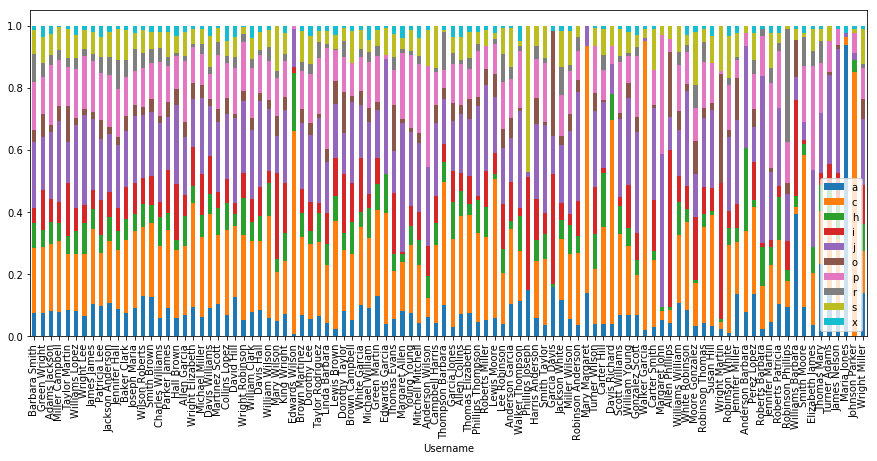

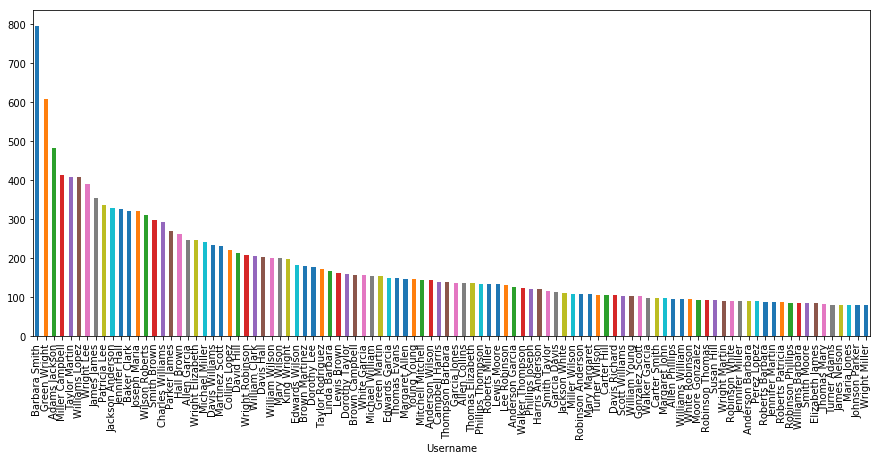

In [11]:
gby.sort_values(by = 'count', ascending = False).head(100).drop('count', axis = 1).plot(kind = 'bar', stacked = True, figsize = (15,6))
plt.figure()
gby.sort_values(by = 'count', ascending = False)['count'].head(100).plot(kind = 'bar', figsize = (15,6));

I think this high diversity should be accounted for when building our predictive model!

It would be interesting to rank the man based on their interest levels(the tags). For instance, we could compute their "skill" by assigning 0 points for "a", 1 for "b" and 2 for "c"...

In [96]:
gby.head(2)

,a,c,h,i,j,o,p,r,s,x,count
Username,,,,,,,,,,,
Adams Jackson,0.080745,0.215321,0.072464,0.072464,0.217391,0.022774,0.190476,0.033126,0.068323,0.026915,483
Allen Collins,0.072993,0.313869,0.080292,0.058394,0.189781,0.029197,0.131387,0.014599,0.072993,0.036496,137


In [112]:
pd.concat([train_df['Tag'].value_counts().sort_values(ascending=False),test_df['Tag'].value_counts().sort_values(ascending=False)],sort=False, axis =1,\
          keys=['Train_Stats', 'Test_Stats'])

,Train_Stats,Test_Stats
c,72458,30793
j,72232,30811
p,43407,18713
i,32400,14100
a,31695,13558
s,23323,10088
h,20564,8782
o,14546,6296
r,12442,5313
x,6978,2994


In [114]:
gby['skill'] = gby['r']*1 + gby['o']*2 + gby['h']*3 + gby['s']*4 + gby['a']*5 + gby['i']*6 + gby['p']*7 + gby['j']*8 \
+ gby['c']*9  

print("Top performers")
gby.sort_values(by = 'skill', ascending = False).reset_index().head()

Top performers


,Username,a,c,h,i,j,o,p,r,s,x,count,skill
0,Walker Garcia,0.020202,0.929293,0.000000,0.000000,0.010101,0.0,0.000000,0.0,0.030303,0.010101,99,8.666667
1,Johnson Parker,0.000000,0.850000,0.037500,0.000000,0.025000,0.0,0.062500,0.0,0.012500,0.012500,80,8.450000
2,Mary Margaret,0.140187,0.794393,0.000000,0.000000,0.065421,0.0,0.000000,0.0,0.000000,0.000000,107,8.373832
3,Davis Richard,0.038095,0.657143,0.085714,0.000000,0.095238,0.0,0.057143,0.0,0.066667,0.000000,105,7.790476
4,Edwards Wilson,0.005495,0.653846,0.186813,0.021978,0.120879,0.0,0.010989,0.0,0.000000,0.000000,182,7.648352


In [115]:
print("\nWorst performers")
gby.sort_values(by = 'skill', ascending = False).reset_index().tail()


Worst performers


,Username,a,c,h,i,j,o,p,r,s,x,count,skill
95,Maria Jones,0.937500,0.025000,0.000000,0.000000,0.012500,0.000000,0.000000,0.000000,0.000000,0.025000,80,5.012500
96,Phillips Joseph,0.148760,0.000000,0.000000,0.363636,0.016529,0.000000,0.000000,0.000000,0.471074,0.000000,121,4.942149
97,Garcia Davis,0.159292,0.000000,0.008850,0.353982,0.123894,0.336283,0.000000,0.000000,0.000000,0.017699,113,4.610619
98,Robinson Phillips,0.094118,0.082353,0.035294,0.094118,0.152941,0.035294,0.129412,0.364706,0.011765,0.000000,85,4.494118
99,Wright Martin,0.022472,0.022472,0.011236,0.438202,0.000000,0.348315,0.011236,0.000000,0.146067,0.000000,89,4.337079


a          0.083726
c          0.244781
h          0.070689
i          0.097548
j          0.213523
o          0.045212
p          0.127928
r          0.031274
s          0.067798
x          0.017520
count    178.100000
skill      6.415586
dtype: float64


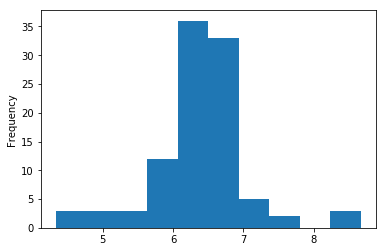

In [117]:
gby.skill.plot(kind = 'hist', bins=10)
print(gby.mean())